# 행렬 분해를 이용한 잠재요인 협업필터링 실습

- 일반적으로 행렬 분해에는 SVD가 자주 사용되지만 사용자-아이템 평점 행렬에는 사용자가 평점을 매기지 않은 널 데이터가 많기 때문에 주로 SGD나 ALS 기반의 행렬분해를 이용함
- 여기서는 SGD 기반의 행렬 분해를 구현하고 이를 기반으로 사용자에게 영화를 추천해보자

In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)

    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]

    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]

    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)

    return rmse

In [30]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다.
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장.
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트.
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)

    return P, Q

In [31]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/drive/MyDrive/ESAA/OB_dataset/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB_dataset/ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index = 'userId', columns = 'movieId')

# title 칼럼을 얻기 위해 movies와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns = 'title'로 title 칼럼으로 pivot 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

이렇게 다시 만들어진 사용자-아이템 평점 행렬을 matrix_factorization() 함수를 이용해 행렬 분해하자. ⤵️

In [32]:
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.2068545530233154
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720406
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.1716522696470749
### iteration step :  120  rmse :  0.16695181946871726
### iteration step :  130  rmse :  0.16305292191997542
### iteration step :  140  rmse :  0.15976691929679646
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.15453398186715425
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  rm

In [33]:
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index=ratings_matrix.index,
                                   columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


이렇게 만들어진 예측 사용자-아이템 평점 행렬 정보를 이용해 개인화된 영화 추천을 해보자. ⤵️

In [34]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함.
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId,:]

    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듬.
    movies_list = ratings_matrix.columns.tolist()

    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [35]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [36]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9) # 사용자 아이디 9번에 대해

# 잠재요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 설정
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


# 파이썬 추천 시스템 패키지 - Surprise

In [37]:
ㅛ!pip uninstall numpy

!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.11/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which 

In [38]:
!pip install scikit-surprise

In [39]:
import surprise

print(surprise.__version__)

1.1.4


In [40]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [41]:
data = Dataset.load_builtin('ml-100k')
# 수행시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

In [42]:
# 잠재 요인 협업 필터링
algo = SVD(random_state=0)
algo.fit(trainset)

surprise에서 추천을 예측하는 메서드는 test()와 predict()

In [43]:
# test()는 사용자-아이템 평점 데이터 세트 전체에 대해 추천을 예측

predictions = algo.test(testset)
print('prediction type:', type(predictions), 'size:', len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

prediction type: <class 'list'> size: 25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.5114147666251547, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.573872419581491, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.033583485472447, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.8463639495936905, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.1807542478219157, details={'was_impossible': False})]

In [44]:
[ (pred.uid, pred.iid, pred.est) for pred in predictions[:3] ]

[('120', '282', 3.5114147666251547),
 ('882', '291', 3.573872419581491),
 ('535', '507', 4.033583485472447)]

In [45]:
# predict는 개별 사용자의 아이템에 대한 추천 평점을 예측

# 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.49   {'was_impossible': False}


In [46]:
# accuracy 모듈은 RMSE, MSE 등으로 추천 시스템의 성능 평가 정보 제공

accuracy.rmse(predictions)

RMSE: 0.9467


0.9466860806937948

## Surprise 주요 모듈 소개

Dataset.load_builtin(name='ml-100k')로 무비렌즈 아카이브 서버에서 자동으로 내려받는 데이터 파일 뿐 아니라 일반 데이터 파일이나 판다스 DataFrame에서도 로딩할 수 있다. 단 **데이터 세트의 칼럼 순서가 사용자 아이디, 아이템 아이디, 평점 순으로 반드시 되어있어야** 함

### OS 파일 데이터를 Surprise 데이터 세트로 로딩

주의할 점: 데이터 파일에 칼럼명을 가지는 헤더 문자열이 있어서는 안됨

In [47]:
import pandas as pd

ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB_dataset/ratings.csv')
# ratings_noh.csv 파일로 인덱스와 헤더를 모두 제거한 새로운 파일 생성
ratings.to_csv('/content/drive/MyDrive/ESAA/OB_dataset/ratings_noh.csv', index=False, header=False)

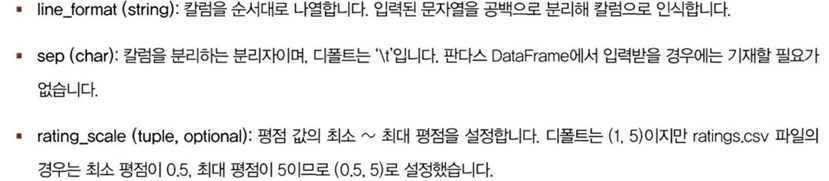

In [48]:
from surprise import Reader

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
data = Dataset.load_from_file('/content/drive/MyDrive/ESAA/OB_dataset/ratings_noh.csv', reader=reader)

In [49]:
# SVD 행렬 분해 기법을 이용해 추천을 예측해보자
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

# 수행시마다 동일한 결과를 도출하기 위해 random_state 설정
algo = SVD(n_factors=50, random_state=0) # 잠재 요인 크기는 50

# 학습 데이터 세트로 학습하고 나서 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

### 판다스 DataFrame에서 Surprise 데이터 세트로 로딩

In [50]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB_dataset/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))

# ratings DataFrame에서 칼럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 한다
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions = algo.test( testset )
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

## Surprise 추천 알고리즘 클래스

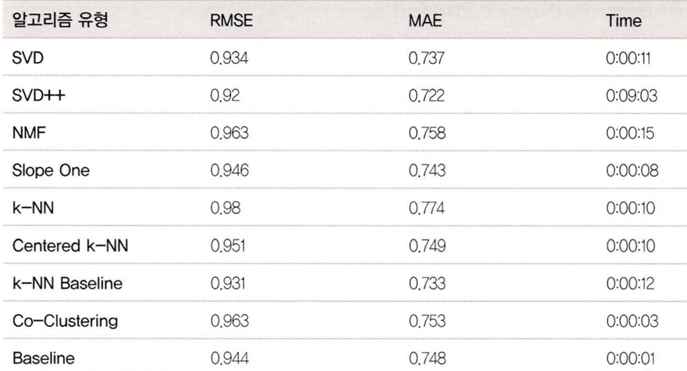

k-NN 자체는 성능이 뒤지지만 Baseline을 결합한 경우 성능 평가 수치가 대폭 향상됐음.

## 베이스라인 평점

- 각 개인이 평점을 부여하는 성향을 반영해 아이템 평가에 편향성 요소를 반영하여 평점을 부과하는 것을 베이스라인 평점이라고 함

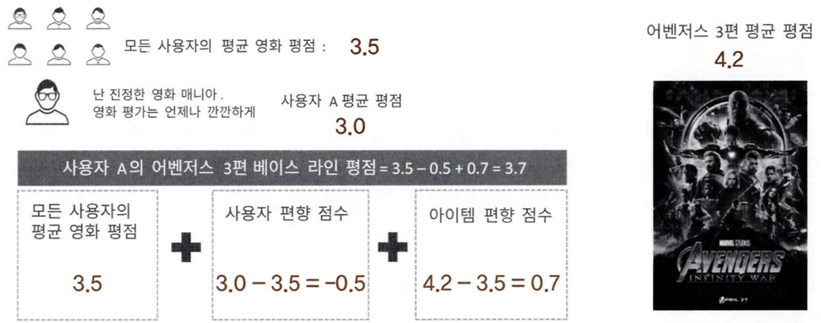

## 교차 검증과 하이퍼 파라미터 튜닝

In [51]:
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB_dataset/ratings.csv') # reading data in pandas df
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8688  0.8809  0.8679  0.8758  0.8726  0.8732  0.0048  
MAE (testset)     0.6697  0.6765  0.6686  0.6715  0.6695  0.6712  0.0028  
Fit time          2.26    1.66    1.58    1.48    1.52    1.70    0.29    
Test time         0.20    0.40    0.12    0.11    0.36    0.24    0.12    


{'test_rmse': array([0.86875695, 0.88092589, 0.86790862, 0.87578182, 0.87258328]),
 'test_mae': array([0.66974362, 0.67645239, 0.66859186, 0.67147973, 0.6695167 ]),
 'fit_time': (2.25653076171875,
  1.6644213199615479,
  1.5755763053894043,
  1.4800050258636475,
  1.5188281536102295),
 'test_time': (0.19577550888061523,
  0.4036438465118408,
  0.12476134300231934,
  0.10723328590393066,
  0.3621196746826172)}

In [52]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정.
param_grid = {'n_epochs': [20, 40, 60], 'n_factors': [50, 100, 200] }

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8776388808022743
{'n_epochs': 20, 'n_factors': 50}


## Surprise를 이용한 개인화 영화 추천 시스템 구축

In [53]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
algo = SVD(n_factors=50, random_state=0)
algo.fit(data)

# Surprise는 데이터세트를 train_test_split을 이용해 내부에서 사용하는 Trainset 클래스 객체로 변환하지 않으면 fit을 통해 학습 불가

AttributeError: 'DatasetAutoFolds' object has no attribute 'n_users'

In [54]:
# 데이터 세트 전체를 학습 데이터로 사용하려면 DatasetAutoFolds 클래스 이용!

from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DataAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성
data_folds = DatasetAutoFolds(ratings_file='/content/drive/MyDrive/ESAA/OB_dataset/ratings_noh.csv', reader=reader)

# 전체 데이터를 학습 데이터로 생성함
trainset = data_folds.build_full_trainset()

In [55]:
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [56]:
# 영화에 대한 상세 속성 정보 DataFrame 로딩
movies = pd.read_csv('/content/drive/MyDrive/ESAA/OB_dataset/movies.csv')

# userId=9의 movieId 데이터를 추출해 movieId=42 데이터가 있는지 확인
movieIds = ratings[ratings['userId']==9]['movieId']

if movieIds[movieIds==42].count() == 0:
    print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])


사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [57]:
uid = str(9)
iid = str(42)

pred = algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


이제 사용자가 평점을 매기지 않은 전체 영화를 추출한 뒤 예측 평점 순으로 영화를 추천해보자

In [58]:
def get_unseen_surprise(ratings, movies, userId):
    #입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
    seen_movies = ratings[ratings['userId']== userId]['movieId'].tolist()

    # 모든 영화들의 movieId를 리스트로 생성.
    total_movies = movies['movieId'].tolist()

    # 모든 영화들의 movieId중 이미 평점을 매긴 영화의 movieId를 제외하여 리스트로 생성
    unseen_movies= [movie for movie in total_movies if movie not in seen_movies]
    print('평점 매긴 영화수:',len(seen_movies), '추천대상 영화수:',len(unseen_movies), \
          '전체 영화수:',len(total_movies))

    return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화수: 46 추천대상 영화수: 9696 전체 영화수: 9742


In [59]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
    # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
    predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

    # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
    # [Prediction(uid='9', iid='1', est=3.69), Prediction(uid='9', iid='2', est=2.98),,,,]
    # 이를 est 값으로 정렬하기 위해서 아래의 sortkey_est 함수를 정의함.
    # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행.
    def sortkey_est(pred):
        return pred.est

    # sortkey_est( ) 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출.
    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions= predictions[:top_n]

    # top_n으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
    top_movie_ids = [ int(pred.iid) for pred in top_predictions]
    top_movie_rating = [ pred.est for pred in top_predictions]
    top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
    top_movie_preds = [ (id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]

    return top_movie_preds

unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)
print('##### Top-10 추천 영화 리스트 #####')

for top_movie in top_movie_preds:
    print(top_movie[1], ":", top_movie[2])


평점 매긴 영화수: 46 추천대상 영화수: 9696 전체 영화수: 9742
##### Top-10 추천 영화 리스트 #####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957




---
정리🧙🏻‍♀️
- 콘텐츠 기반 필터링: 콘텐츠를 구성하는 여러 요소(예를 들어, 영화라면, 장르/감독/배우/영화 키워드 등)를 결합하여 하나의 콘텐츠 특징으로 피처 벡터화 한 뒤 이들 피처 벡터와 가장 유사한 다른 피처 벡터를 가진 영화를 추천하는 것

- 협업 필터링: 최근접 이웃 협업 필터링과 잠재요인 협업 필터링으로 나뉨. 최근접 이웃 필터링인 사용자 기반과 아이템 기반으로 나뉜다. 이중 아이템 기반이 더 많이 사용되는데, 모든 아이템을 행으로, 모든 사용자를 열로, 그리고 사용자별 아이템 평점을 값으로 하는 아이템-사용자 행렬을 만들고, 아이템 별로 코사인 유사도를 이용해 사용자 평점 피처 벡터에 따른 top-n 유사 아이템을 추천하는 예제 있었음

- 잠재 요인 협업 필터링: 사용자-아이템 행렬 데이터에 숨어있는 잠재요인을 추출하여 사용자가 아직 평점을 매기지 않은 데이터에 대한 평점을 예측하여 이를 추춘해 반영하는 방식. 이렇게 잠재 요인을 추출하기 위해서 행렬 분해를 이용한다.

- 파이썬의 추천 시스템 패키지 중 하나인 Surprise 이용해봄
